# Calibration data processing for the CHEESE eclipse experiment, April 8 2024

## 1. Load all the tidbits

In [2]:
import numpy as np
from scipy import interpolate
from astropy.io import fits
import matplotlib.pyplot as pl
import scipy.optimize as opt
import os
import matplotlib.colors as colors
from skimage.transform import rotate
from astropy import time 
from sunpy.net import Fido, attrs as a

# pl.style.use('/glade/u/home/mmolnar/.mpl_stylesheet')
# Set default thickness for axis lines (spines) and ticks in rcParams
pl.rcParams['axes.linewidth'] = 1.5  # Axis line (spines) width
pl.rcParams['xtick.major.width'] = 1.0  # Major x-tick width
pl.rcParams['ytick.major.width'] = 1.0  # Major y-tick width
pl.rcParams['xtick.minor.width'] = 1.0  # Minor x-tick width
pl.rcParams['ytick.minor.width'] = 1.0  # Minor y-tick width
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['ytick.direction'] = 'out'

# Set default font size and weight for labels
pl.rcParams['axes.labelsize'] = 14  # Axis label font size
pl.rcParams['axes.labelweight'] = 'bold'  # Axis label font weight
pl.rcParams['xtick.labelsize'] = 12  # X-tick label font size
pl.rcParams['ytick.labelsize'] = 12  # Y-tick label font size
pl.rcParams['font.weight'] = 'bold'  # General font weight

import sunpy.map
import sunpy.sun
from sunpy.coordinates import get_body_heliographic_stonyhurst

from dataReductionSoftware import spectrum
# from dataReductionSoftware import fit_line

from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib as mp

import sys

# Add the path to the directory containing the file you want to import
sys.path.append('/Users/memolnar/Tools/solar_atlas/solaratlas/')
import atlastools


import matplotlib
matplotlib.use('qtagg')

fig_width_pt = 347  # Get this from LaTeX using \show\the\columnwidth
inches_per_pt = 1.0/72               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = {'backend': 'ps',
          'axes.labelsize': 10,
        #   'text.fontsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': True,
          'figure.figsize': fig_size,
          'axes.labelpad': 0}
mp.rcParams.update(params)



def line(x, a, b):
        return a*x + b

def fit_line(x, y):
    popt, pcov = opt.curve_fit(line, x, y)
    return popt

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n




Matplotlib created a temporary cache directory at /var/folders/8n/b1dtjbc56x18z6fppp7h_7480000gp/T/matplotlib-adzfus1s because the default path (/Users/memolnar/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


## 1.1 Load all the data

In [3]:

data_dir = "/Users/memolnar/Work/Hanle_CME_Bz/CHEESE_data/24_04_08_Eclipse_data/sunspot_data/"


files     = os.listdir(data_dir)

# darks = os.listdir(darks_dir)
# cal_data = os.listdir(cal_dir)

num_files = len(files)
# num_darks = len(darks)
# num_cal = len(cal_data)

print(f"Number of files:{num_files}")

Number of files:101


2024-12-31 13:07:32.546 python[75523:4432580] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-31 13:07:32.546 python[75523:4432580] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [3]:

print(files[0])
with fits.open(data_dir + files[1]) as hdul:
    print(f"Data shape is {hdul[0].data.shape}")
    print(hdul[0].header)
    nx = hdul[0].data.shape[0]
    ny = hdul[0].data.shape[1]
    print(hdul[0].header)
    
data_array = np.zeros((num_files, nx, ny))
files.sort()
print(files)

for el in range(num_files-1):
    with fits.open(data_dir + files[el+1]) as hdul:    
        data_array[el, :, :] = hdul[0].data[:, :, 0]



sunspots82
Data shape is (1024, 1280, 1)
SIMPLE  =                    T                                                  BITPIX  =                   16                                                  NAXIS   =                    3                                                  NAXIS1  =                    1                                                  NAXIS2  =                 1280                                                  NAXIS3  =                 1024                                                  DATAMIN =                    0                                                  DATAMAX =                 4095                                                  DATE    = '2024-04-08T08:12:21'                                                 DATE_OBS= '2024-04-08T08:12:21'                                                           AXIS1UNT= 'Grey scale monochrome'                                     END                                                                            

In [4]:
mean_image = np.nanmean(data_array[0:1, :, :], axis=0)

# mean_dark = np.nanmean(darks_array, axis=0)

# mean_cal = np.nanmean(cal_array, axis=0)


print(mean_image.shape)

av_spectrum = np.median(mean_image[400:800, :], axis=0)
N = 100
av_spectrum_smooth = np.array([np.convolve(el, np.ones(N)/N, mode='same')
                               for el in mean_image])
print(av_spectrum.shape)
pl.plot(av_spectrum_smooth[300, :])
pl.show() 

(1024, 1280)
(1280,)


In [5]:
pl.close() 


fig, ax = pl.subplots()
fig.set_dpi(250)

av_spectrum = np.mean(mean_image[350:500, :], axis=0)

background = np.mean(mean_image[950:1000, :], axis=0)

rotAngle = 1.5
gammaShade = 0.83


im_processed = (mean_image)
im_processed = rotate(im_processed, rotAngle)
N = 200
av_spectrum_smooth = [np.convolve(el, np.ones(N)/N, mode='same')
                      for el in im_processed]

im_processed = im_processed / av_spectrum_smooth
# av_background = np.mean(im_processed, axis=1)

im1 = ax.imshow(im_processed,
                origin="lower", cmap="Greys_r",
                aspect="auto", norm=colors.LogNorm(vmax=1.3, vmin=0.8))
                #  vmax=1.2, vmin = 0,               
ax.set_title("CHEESE 1079 wavelength range IR Spectrum")
pl.xlabel("wavelength")
pl.ylabel("Slit [pixels]")
pl.colorbar(im1)
pl.grid(alpha=0.1, color="cyan")
# pl.xlim(10800, 10840)
pl.xlim(250, 280)
# pl.ylim(600, 800)
pl.savefig("/Users/mmolnar/Writing/Papers/2024b_Molnar_Eclipse_results/eclipse_paper/figures/CHEESE_first_solar_spectrum.png")
pl.show() 

/var/folders/gq/_rzgdmzn6q5_g_84yyw4tgzh0000gp/T/ipykernel_49599/4218364423.py:21: RuntimeWarning: invalid value encountered in divide
  im_processed = im_processed / av_spectrum_smooth


In [6]:
pl.clf() 

dataCHEESE = spectrum(im_processed, [20, 1003])
lineList = {"11032": [147, 158], "10965": [340, 349], "10931": [440, 448], "10914": [485, 494], 
            "10901": [525, 535], "10892": [550, 560], "10889": [560, 570], "10885": [570, 578],
            "10869": [615, 625], "10860": [642, 650], "10843": [687, 698],
            "10827": [736, 744], "10811": [782, 790], "10800": [816, 822], 
            "10787": [850, 860], "10749": [955, 965], "10707": [1072, 1085]}
dataCHEESE.compute_lines(lineList)

dataCHEESE.compute_dispersion(smoothLineFits=False, smoothLineFitsSigma=12)
dataCHEESE.recomputeUniformGrid()

pl.figure(dpi=125)
pl.imshow(im_processed, origin="lower", cmap="Greys_r",
                aspect="auto", norm=colors.LogNorm(vmax=1.4, vmin=0.9))

pl.grid(alpha=0.3)

for el in dataCHEESE.lineDict:
    numX = len(dataCHEESE.lineDict[el]) 
    xdim = np.linspace(dataCHEESE.rawSpectrumLimits[0],
                       dataCHEESE.rawSpectrumLimits[1], num=numX)
    pl.plot(dataCHEESE.lineDict[el], xdim, label=el)
    pl.legend()



pl.xlim(0, 1280)
pl.show()

im1 = pl.imshow(dataCHEESE.dispersionGrid, 
                cmap="cubehelix", aspect="auto", vmin=11100, vmax=10650)
pl.colorbar(im1)
# pl.xlim(400, 800)

pl.show()

# dataCHEESE.saveDispersionGrid("/Users/mmolnar//Work/Hanle_CME_Bz/CHEESE_data/24_04_08_Eclipse_data/dispersion_file.npz")


Fitting 11032 Å line
Fitting 10965 Å line
Fitting 10931 Å line
Fitting 10914 Å line
Fitting 10901 Å line
Fitting 10892 Å line
Fitting 10889 Å line
Fitting 10885 Å line
Fitting 10869 Å line
Fitting 10860 Å line
Fitting 10843 Å line
Fitting 10827 Å line
Fitting 10811 Å line
Fitting 10800 Å line
Fitting 10787 Å line
Fitting 10749 Å line
Fitting 10707 Å line
Shape of dispCoeff: (983, 3)
recomputing Uniform grid
(20, 1003)


In [7]:
import numpy as np
from astropy.io import fits
from astropy import units as u
pl.clf() 

atlas_files_base = '/Users/mmolnar/Tools/solar_atlas/solaratlas/'
file  = atlas_files_base + 'neckel.hamburg.atlas.wvscl_smooth.bintab.v3.fits'
#file  = atlas_files_base + 'stenflo.SS3.5mA.bintab.v2.fits'
#file  = atlas_files_base + 'kitt.peak.ir.1-5micron.atlas.wavelnth.bintab.fits.gz'
#file  = atlas_files_base + 'kitt.peak.quietsun.350-740nm.1998.v1.fits.gz'

extension   = 1
atlasdict_1 = atlastools.make_dictionary(file,1)
fileopen    = fits.open(file, memmap=True)

atlas_name  = fileopen[1].header['ATL_NAME']

wave_col_id = fileopen[0].header['ATLWVCOL']
waveref_col = (atlastools.find_column_index(atlasdict_1, wave_col_id))[0].pop()
wavemin     = atlastools.search_key('TDMIN' + waveref_col[0], atlasdict_1)
wavemax     = atlastools.search_key('TDMAX' + waveref_col[0], atlasdict_1)
waveunit    = (atlastools.search_key('TCUNI' + waveref_col[0], atlasdict_1))[0]
waveunit_ap = atlastools.tunit_str_to_unit(waveunit[0])
wavemin     = wavemin[0] * waveunit_ap
wavemax     = wavemax[0] * waveunit_ap

print("Atlas Name: ",atlas_name)
print("Overall Wavelength Interval: ",wavemin," - ",wavemax)

filemap = atlastools.filecontent_map(file)
filemap.file_info()
filemap.list_extensions()

extension = 1
atlas = atlastools.make_atlas(file, 1, loaddata=1, startwave=1080*u.nm, endwave=1085*u.nm)

atlasWavelength = atlas.components['Local Flux   1'].wavelength
atlasIntensity  = atlas.components['Local Intensity   1'].flux

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

gaussianPSF = gaussian(atlasWavelength.value, 10820, 10820/8200/2.35)
pl.plot(atlasWavelength.value, gaussianPSF)
atlasIconvolved = np.convolve(atlasIntensity.value, 
                              gaussianPSF, mode='same')
pl.plot(atlasWavelength.value, atlasIconvolved)
# print(atlasIconvolved.shape)    
pl.show()

Atlas Name:  Neckel/Hamburg/FTS Normalized Atlas 1999
Overall Wavelength Interval:  [329.00013] nm  -  [1250.99824853] nm
General file information:

Object: Sun
Atlas source: Neckel/Hamburg/FTS 1999
Atlas acquisition site: Kitt Peak Observatory
Atlas wavelength coverage: 329.00 nm – 1251.00 nm
Number of Extensions: 2

EXTENSION 1:

	Waveranges per column:

	Column 0 wavelength range: (329.00013, 1250.99824853) Nanometers
	Column 1 wavelength range: (3.58625e-05, 1.01019) Relint
	Column 2 wavelength range: (762.12, 4666.06) W m^(-2) sr^(-1) Angstrom^(-1)


	Specific column components:

	Column 0:
	 Wavelength Scale   --   1
	Column 1:
	 Local Intensity   --   1
	Column 2:
	 Local Flux   --   1


checking  ['Wavelength Scale   1', 'Local Intensity   1', 'Local Flux   1']
keywords  ['TTYPE1', 'TTYPE2', 'TTYPE3']
Wavelength Scale   1
Primary Wavelength Scale TTYPE1 Wavelength Scale   1
Local Intensity   1
Local Flux   1
Wavelength Scale   1 [['1']]
<class 'str'> Nanometers
3696
populating 

In [20]:
fig_size =  [fig_width,fig_height/1.2]
props_textbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fontsize_labels = 7 

startLinePlot = -462*dataCHEESE.plateScale / 60
endLinePlot   =  462*dataCHEESE.plateScale / 60


fig  = pl.figure(dpi=250, figsize=fig_size)

# make a matplotlib pyplot gridspec plot
gs = fig.add_gridspec(100, 100)

ax0 = fig.add_subplot(gs[:, 0:45])

ax10 = fig.add_subplot(gs[0:48, 60:100])
ax11 = fig.add_subplot(gs[52:100, 60:100])

im1 = ax0.imshow(dataCHEESE.spectrumUniform[50:-50], origin="lower", cmap="Greys_r",
            aspect="auto", norm=colors.LogNorm(vmax=1.2, vmin=0.8),
            extent = [dataCHEESE.lambdaUniform[0],dataCHEESE.lambdaUniform[-1],
                     startLinePlot, 
                     endLinePlot])
ax0.set_xlim(10700, 11050)
# pl.colorbar(im1, ax=ax[0])
ax0.grid(alpha=0.5)
ax0.set_ylabel("Solar Y [arcmin]",
               labelpad = 0)
ax0.text(10720.5, 18.5, '(a) CHEESE Full spectrum', 
         fontsize=fontsize_labels,
         verticalalignment='top', bbox=props_textbox)
ax0.set_ylim(-20, 20)

# for el in ax.flatten():
#     el.tick_params(axis='both', which='major')  # Change tick label size

# 
for el in dataCHEESE.lineDict:
     
    numX = int(endLinePlot - startLinePlot)

    xdim = np.linspace(startLinePlot,
                       endLinePlot, 
                       num=numX)
    
    ax0.plot([float(el)] * int(numX), xdim, '--', linewidth=.5)

ax10.imshow(dataCHEESE.spectrumUniform[50:-50], origin="lower", cmap="Greys_r",
          aspect="auto", norm=colors.LogNorm(vmax=1.2, vmin=0.8),
          extent = [dataCHEESE.lambdaUniform[0],dataCHEESE.lambdaUniform[-1], 
                    startLinePlot, 
                    endLinePlot])


ax10.set_xlim(10805, 10845)
ax10.set_ylabel("Solar Y [arcmin]",
               labelpad = 2)
ax10.set_xticklabels([])    


cutout_range = [400, 600]

ax10.plot(dataCHEESE.lambdaUniform,
          np.linspace((cutout_range[0]-1024/2)/60,
                      (cutout_range[0]-1024/2)/60, 
                       num=len(dataCHEESE.lambdaUniform)), 
                       '--', linewidth=0.5,
                       color="magenta")
ax10.plot(dataCHEESE.lambdaUniform,
          np.linspace((cutout_range[1]-1024/2)/60,
                      (cutout_range[1]-1024/2)/60, 
                      num=len(dataCHEESE.lambdaUniform)), '--', linewidth=0.5,
                      color="magenta")
ax10.text(10807.5, 17.5, '(b) He I 1083 nm', fontsize=fontsize_labels,
          verticalalignment='top', bbox=props_textbox)
ax10.set_ylim(-20, 20)
continuum_level = np.nanmedian(dataCHEESE.spectrumUniform[cutout_range[0]:cutout_range[1], :],
                               axis=(0, 1))
meanData = np.mean(dataCHEESE.spectrumUniform[cutout_range[0]:cutout_range[1], :],
                   axis=0) / continuum_level

ax11.plot(dataCHEESE.lambdaUniform,
          meanData,
          '.--', label="CHEESE", markersize=3, linewidth=0.5)
ax11.set_xlim(10805, 10845)
ax11.set_ylabel("Intensity",
               labelpad = 6.9)
ax11.plot(atlasWavelength.value+4.55,
          atlasIconvolved * 7.19887769e-03 + 2.63095724e-01, 
          label="Atlas", 
          linewidth=0.5)

ax11.legend(fontsize=5, loc="lower right")
# add a textbox with smooth edges
ax11.text(10807.5, 1.05, '(c) Atlas comparison', fontsize=fontsize_labels,
        verticalalignment='top', bbox=props_textbox)

ax11.set_ylim(0.78, 1.075)

ax_array = [ax0, ax10, ax11]

for el in ax_array:
    el.set_xlabel("Wavelength [Å]")
    el.grid(alpha=0.8, linewidth=0.25)

pl.savefig("/Users/mmolnar/Writing/Papers/2024b_Molnar_Eclipse_results/eclipse_paper/figures/Calibration_data.pdf", 
           format="pdf", bbox_inches = 'tight')

pl.show()
pl.clf()

In [19]:
# interpolate atlasIconvolved as a function atlasWavelength with scipy


def f_I_multiComponent(wavelength, scaling, scatterLight, R):
    gaussianPSF = gaussian(atlasWavelength.value, 10820, (10820/(R*1.2))/2.35)
    atlasIconvolved = np.convolve(atlasIntensity.value, 
                                  gaussianPSF, mode='same')
    f_I = interpolate.interp1d(atlasWavelength.value+4.55, 
                               atlasIconvolved, 
                               kind='cubic')
    return scaling * f_I(wavelength) + scatterLight

wave_range = [10805, 10845]
dataCheesewaveind = [np.argmin(np.abs(dataCHEESE.lambdaUniform - wave_range[0])),
                     np.argmin(np.abs(dataCHEESE.lambdaUniform - wave_range[1]))]

# fit f_I_multiComponent coefficients to fit to the multiData
popt, pcov = opt.curve_fit(f_I_multiComponent, 
                           dataCHEESE.lambdaUniform[dataCheesewaveind[0]:dataCheesewaveind[1]],
                           meanData[dataCheesewaveind[0]:dataCheesewaveind[1]], 
                           p0=[0.0006, 0.02254, 12600])

print(popt)

[7.20249867e-03 2.62787511e-01 6.80467190e+03]


In [12]:
# make a gaussian with a given FWHM


pl.plot(dataCHEESE.lambdaUniform, gaussian) 

# convolve the gaussian with the spectrum


ValueError: x and y must have same first dimension, but have shapes (1180,) and (1,)

## Make the map of observed region

In [8]:
from matplotlib import pyplot as plt

import sunpy.map
# from sunpy.instr.aia import aiaprep
from sunpy.net import Fido, attrs as a

from astropy.coordinates import SkyCoord, EarthLocation
from astropy import units as u

import warnings
warnings.filterwarnings("ignore")

observingLocationCalibration = EarthLocation.of_address("Little Rock, AR")

angleCalibration = sunpy.coordinates.sun.orientation(observingLocationCalibration,
                                                     time="2024-04-08T16:01:00")


In [9]:
# download and plot AIA map from April 8, 2024
angleCalibration = sunpy.coordinates.sun.orientation(observingLocationCalibration,
                                                     time="2024-04-08T13:01:00") + 23.4 * u.deg


result_AIA1600 = Fido.search(a.Time("2024-04-08T13:00:00", "2024-04-08T13:01:00"),
                     a.Instrument("AIA"),
                     a.Wavelength(1600*u.angstrom))



result_AIA304 = Fido.search(a.Time("2024-04-08T13:00:00", "2024-04-08T13:01:00"),
                     a.Instrument("AIA"),
                     a.Wavelength(304*u.angstrom))


result_AIA171 = Fido.search(a.Time("2024-04-08T13:00:00", "2024-04-08T13:01:00"),
                            a.Instrument("AIA"),
                            a.Wavelength(171*u.angstrom))



In [10]:

downloaded_files_AIA171 = Fido.fetch(result_AIA171[0])
downloaded_files_AIA304 = Fido.fetch(result_AIA304[0])
downloaded_files_AIA1600 = Fido.fetch(result_AIA1600[0])

Files Downloaded:   0%|          | 0/5 [00:00<?, ?file/s]

aia.lev1.171A_2024_04_08T13_00_45.35Z.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1.171A_2024_04_08T13_00_33.35Z.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1.171A_2024_04_08T13_00_09.35Z.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1.171A_2024_04_08T13_00_57.35Z.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1.171A_2024_04_08T13_00_21.35Z.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/5 [00:00<?, ?file/s]

aia.lev1.304A_2024_04_08T13_00_29.13Z.image_lev1.fits:   0%|          | 0.00/7.49M [00:00<?, ?B/s]

aia.lev1.304A_2024_04_08T13_00_05.13Z.image_lev1.fits:   0%|          | 0.00/7.49M [00:00<?, ?B/s]

aia.lev1.304A_2024_04_08T13_00_53.13Z.image_lev1.fits:   0%|          | 0.00/7.49M [00:00<?, ?B/s]

aia.lev1.304A_2024_04_08T13_00_41.13Z.image_lev1.fits:   0%|          | 0.00/7.49M [00:00<?, ?B/s]

aia.lev1.304A_2024_04_08T13_00_17.13Z.image_lev1.fits:   0%|          | 0.00/7.49M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

aia.lev1.1600A_2024_04_08T13_00_14.13Z.image_lev1.fits:   0%|          | 0.00/8.47M [00:00<?, ?B/s]

aia.lev1.1600A_2024_04_08T13_00_38.13Z.image_lev1.fits:   0%|          | 0.00/8.47M [00:00<?, ?B/s]

2024-12-17 15:04:20 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2024-12-17 15:04:21 - reproject.common - INFO: Calling _reproject_full in non-dask mode


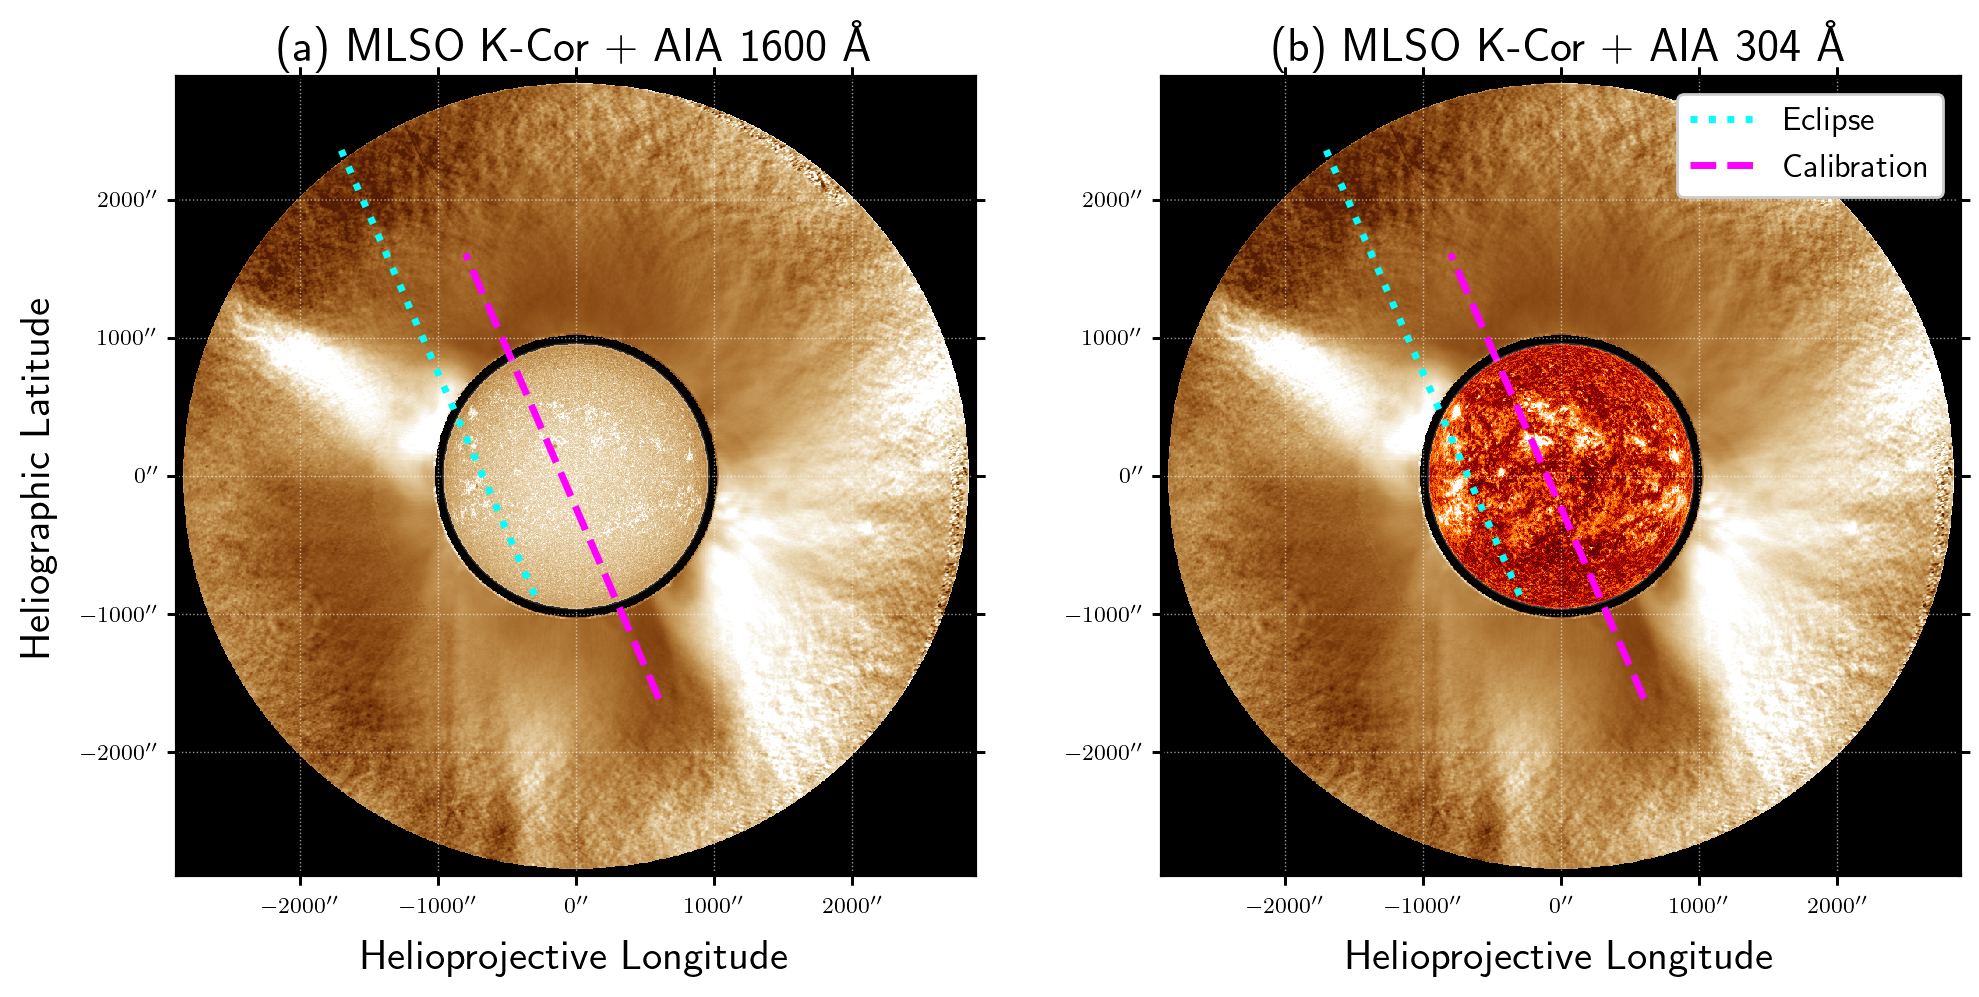

In [18]:
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.visualization import ImageNormalize, SqrtStretch, AsinhStretch

import matplotlib as mp

import sunpy
from sunpy.map import Map
from sunpy.map.header_helper import make_fitswcs_header
from sunpy.coordinates.frames import Helioprojective, HeliographicStonyhurst

import matplotlib.pyplot as plt
mp.use('pgf')

%matplotlib inline


angleCalibration = (23.5 + 90) * u.deg
angleExperiment  = (23.5 + 90) * u.deg

fig_width_pt = 347  # Get this from LaTeX using \show\the\columnwidth
inches_per_pt = 1.0/72               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = {'backend': 'ps',
          'axes.labelsize': 10,
        #   'text.fontsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': True,
          'figure.figsize': fig_size}
mp.rcParams.update(params)



with fits.open("/Users/memolnar/Work/Hanle_CME_Bz/CHEESE_data/24_04_08_Eclipse_data/20240409.kcor_nrgfextavg.fits/20240409_174852_kcor_l2_nrgf_extavg.fts.gz") as hdu:
    pB = hdu[0].data
    header = hdu[0].header
kcor_map = Map(pB, header)
norm = ImageNormalize(pB, vmin=-2.5, vmax=2)



# plot aia map
aia_map_1600 = sunpy.map.Map(downloaded_files_AIA1600[0])
aia_map_304 = sunpy.map.Map(downloaded_files_AIA304[0])

slitLength = 1024*3.43*u.arcsec
slitCoords_calibration = [-100, 0] * u.arcsec
slitCoords_experiment  = [-1000, 750] * u.arcsec


lim_xgrid = 1750
xlims_world = [-lim_xgrid, lim_xgrid]*u.arcsec
ylims_world = [-lim_xgrid, lim_xgrid]*u.arcsec

def plot_slit(axs, sunpyMap, slitCoords):
    lim_xgrid = 1750
    xlims_world = [-lim_xgrid, lim_xgrid]*u.arcsec
    ylims_world = [-lim_xgrid, lim_xgrid]*u.arcsec  

    world_coords = SkyCoord(Tx=xlims_world, Ty=ylims_world, frame=sunpyMap.coordinate_frame)
    pixel_coords_x, pixel_coords_y = sunpyMap.wcs.world_to_pixel(world_coords)
    pixel_coords_x_slit = (slitCoords[0]
                           + np.linspace(-0.5 * slitLength * np.cos(np.deg2rad(angleCalibration)),
                                      0.5 * slitLength * np.cos(np.deg2rad(angleCalibration)), 
                                      num=100))
    pixel_coords_y_slit = (slitCoords[1] 
                           + np.linspace(-0.5 * slitLength * np.sin(np.deg2rad(angleCalibration)),
                                      0.5 * slitLength * np.sin(np.deg2rad(angleCalibration)), 
                                      num=100)) 

    ax.plot(pixel_coords_x_slit.to(u.deg),
            pixel_coords_y_slit.to(u.deg), 
            transform=ax.get_transform("world"),
        color="red", linewidth=0.5)
    
    return 0

# write me a script to create 1 x 3 subplot figure with AIA maps
# and the slit overlaid on the maps

# create a figure with gridspec 

fig = plt.figure(figsize=(10, 5), dpi=200)
gs = fig.add_gridspec(1, 2)

# make first subplot with AIA 1600 map
ax1 = fig.add_subplot(gs[0, 0], projection=kcor_map)

kcor_map.plot(axes=ax1, cmap='sdoaia193', norm=norm)
aia_map_reproject_1600 = aia_map_1600.reproject_to(WCS(header))

norm_aia_1600 = ImageNormalize(aia_map_1600.data, stretch=AsinhStretch(), 
                              vmin=4, vmax=100)
aia_map_reproject_1600.plot(axes=ax1, cmap='sdoaia193', 
                           norm=norm_aia_1600, autoalign=True)
aia_map_reproject_1600.draw_limb(axes=ax1, alpha=0.2)
# aia_map_reproject_304.draw_grid(axes=ax2)

ax1.set_facecolor('black')
ax1.set_title("(a) MLSO K-Cor + AIA 1600 \AA", 
              fontsize=17)
ax1.set_ylabel("Heliographic Latitude", fontsize=15)

# axexp_xlabel("Solar X [arcsec]")
# ax1.set_xlabel("Solar X [arcsec]")
# overlay the slit on the map


world_coords = SkyCoord(Tx=xlims_world, Ty=ylims_world, 
                        frame=kcor_map.coordinate_frame)

pixel_coords_x, pixel_coords_y = kcor_map.wcs.world_to_pixel(world_coords)
pixel_coords_x_slit_calib = (slitCoords_calibration[0]
                             + np.linspace(-0.5 * slitLength * np.cos(np.deg2rad(angleCalibration)),
                             0.5 * slitLength * np.cos(np.deg2rad(angleCalibration)), 
                             num=100))
pixel_coords_y_slit_calib = (slitCoords_calibration[1] 
                             + np.linspace(-0.5 * slitLength * np.sin(np.deg2rad(angleCalibration)),
                             0.5 * slitLength * np.sin(np.deg2rad(angleCalibration)), 
                             num=100))

pixel_coords_x_slit_exp   = (slitCoords_experiment[0]
                             + np.linspace(-0.5 * slitLength * np.cos(np.deg2rad(angleExperiment)),
                             0.5 * slitLength * np.cos(np.deg2rad(angleExperiment)), 
                             num=100))
pixel_coords_y_slit_exp   = (slitCoords_experiment[1] 
                             + np.linspace(-0.5 * slitLength * np.sin(np.deg2rad(angleExperiment)),
                             0.5 * slitLength * np.sin(np.deg2rad(angleExperiment)), 
                             num=100))


# make second subplot with AIA 304 map
ax2 = fig.add_subplot(gs[0, 1], projection=kcor_map)

kcor_map.plot(axes=ax2, cmap='sdoaia193', norm=norm)
aia_map_reproject_304 = aia_map_304.reproject_to(WCS(header))

norm_aia_304 = ImageNormalize(aia_map_304.data, 
                              stretch=AsinhStretch(), 
                              vmin=0, vmax=40)

aia_map_reproject_304.plot(axes=ax2, cmap='sdoaia304', 
                           norm=norm_aia_304, autoalign=True)
aia_map_reproject_304.draw_limb(axes=ax2, alpha=0.2)
# aia_map_reproject_304.draw_grid(axes=ax2)

ax2.set_facecolor('black')

ax2.set_title("(b) MLSO K-Cor + AIA 304 \AA", 
              fontsize=17)

ax2.set_ylabel(" ", fontsize=15) 
ax_array = [ax1, ax2]

for el in ax_array:
    
    el.plot(pixel_coords_x_slit_exp.to(u.deg),
             pixel_coords_y_slit_exp.to(u.deg), 
             transform=el.get_transform("world"), linestyle='dotted',
             color="cyan", linewidth=2.5, label="Eclipse")
    
    el.set_xlabel('Helioprojective Longitude', 
                   fontsize=15)
    el.plot(pixel_coords_x_slit_calib.to(u.deg),
            pixel_coords_y_slit_calib.to(u.deg), linestyle='dashed',
            transform=el.get_transform("world"),
            color="magenta", linewidth=2.5, label="Calibration")

ax2.legend(fontsize=12, fancybox=True, framealpha=1.0)
plt.tight_layout()
plt.savefig("/Users/memolnar/Writing/Papers/2025a_Molnar_Eclipse_results"
            + "/eclipse_paper/figures/AIA_maps_with_slit.png", format="png",
            bbox_inches='tight')
plt.show() 
plt.clf()  # Clear the current figure

In [ ]:
_ = pl.hist(pB.flatten(), bins=100)
pl.imshow(pB, norm=norm)

In [12]:
header

SIMPLE  =                    T / Written by IDL:  Sun Sep  8 19:40:33 2024      
BITPIX  =                  -32 / 16-bit twos complement binary integer          
NAXIS   =                    2 / number of dimensions; FITS image               
NAXIS1  =                 1024 /Number of positions along axis 1                
NAXIS2  =                 1024 /Number of positions along axis 2                
EXTEND  =                    F / no FITS extensions                             
DATE-OBS= '2024-04-09T17:48:52' / UTC observation start                         
DATE-END= '2024-04-09T18:02:31' / UTC observation end                           
MJD-OBS =      60409.742268519 / [days] modified Julian date                    
MJD-END =      60409.742442130 / [days] modified Julian date                    
TIMESYS = 'UTC     '           / date/time system: Coordinated Universal Time   
DATE_HST= '        '           / MLSO observation date [HST]                    
LOCATION= 'MLSO    '        

In [ ]:
# plot aia map

timeObs = time.Time("2024-04-08 20:08:10", scale='utc')
angleObservation = sunpy.coordinates.sun.orientation(observingLocationCalibration,
                                                     time=timeObs)

slitLength = 1024*3.43*u.arcsec
slitCoords = [-650, 400] * u.arcsec

fig = plt.subplots(1, 2, dpi=100, figsize=(5, 5))
# ax = fig.add_subplot(projection=aia_map)
aia_mapEclipse304.plot(axes=ax[0], clip_interval=(50, 95.)*u.percent)
aia_mapEclipse304.draw_limb(axes=ax)
# aia_map.draw_grid(axes=ax)

lim_xgrid = 3500
xlims_world = [-2000, 1500]*u.arcsec
ylims_world = [-1500, 2200]*u.arcsec

world_coords = SkyCoord(Tx=xlims_world, Ty=ylims_world, frame=aia_map.coordinate_frame)
pixel_coords_x, pixel_coords_y = aia_map.wcs.world_to_pixel(world_coords)
pixel_coords_x_slit = (slitCoords[0]
                       + np.linspace(-0.5 * slitLength * np.cos(np.deg2rad(angleObservation)),
                                  0.5 * slitLength * np.cos(np.deg2rad(angleObservation)), 
                                  num=100))
pixel_coords_y_slit = (slitCoords[1] 
                       + np.linspace(-0.5 * slitLength * np.sin(np.deg2rad(angleObservation)),
                                  0.5 * slitLength * np.sin(np.deg2rad(angleObservation)), 
                                  num=100))

ax.plot(pixel_coords_x_slit.to(u.deg),
        pixel_coords_y_slit.to(u.deg), 
        transform=ax.get_transform("world"),
        color="lime", linewidth=0.5)
ax.set_xlim(pixel_coords_x)
ax.set_ylim(pixel_coords_y)

# set background of the plot to be black 
ax.set_facecolor('black')



plt.show()



In [19]:
### Compute line temperatures

In [35]:
kb = 1.38e-23
l0 = 1083e-9
mp = 1.67e-27
mHe = 4 * mp 
mfe = 55.845 * mp 
wI = l0/9000
c = 3e8 

fwhm_1074 = 0.85e-10 * 2.32
fwhm_1083 = 0.65e-10 * 2.32

def temp(FWHM, mAtom, l0, wI):
    return mAtom / (2 * kb) * ( (FWHM ** 2 - wI ** 2) / (4 * np.log(2) * (l0/c)**2))
    
print(f"Fe XIII temperature: {temp(fwhm_1074, mfe, 1074e-9, wI)}")
print(f"Fe XIII temperature: {temp(fwhm_1083, mHe, 1080e-9, wI)}")

Fe XIII temperature: 2320959.4314237223
Fe XIII temperature: 55639.70015155447


In [26]:
np.log(2)

0.6931471805599453